# Cluster For Fake and Not-Fake Data


In [ ]:
!pip install transformers -q

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


# Load your dataset
df = pd.read_excel('constraint_dataset.xlsx')

# Filter data with 'Hate' label
fake_data = df[df['New Labels'] == 0]

# Initialize mBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

# Tokenize the input texts
tokenized_data = fake_data['preprocessed_text'].apply(lambda x: tokenizer(str(x), padding=True, truncation=True, return_tensors='pt'))

# Extract embeddings
embeddings = []
for input_ids in tokenized_data:
    with torch.no_grad():
        outputs = model(**input_ids)

    hidden_states = outputs.last_hidden_state
    embeddings.append(hidden_states[:, 0, :].numpy())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Save the embeddings as a PyTorch tensor
embeddings = torch.tensor(embeddings)

# Save the embeddings to a file named 'embeddings.pt'
torch.save(embeddings, 'Not_Fake_Hin_embeddings.pt')

<ipython-input-3-317fa123962f>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  embeddings = torch.tensor(embeddings)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


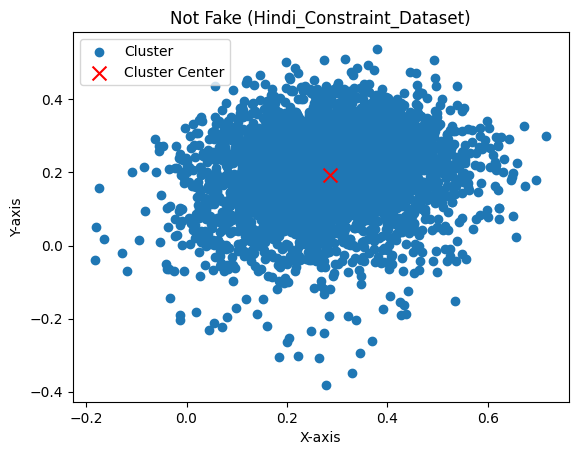

In [ ]:
import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load your embeddings from the file
embeddings = torch.load('Not_Fake_Hin_embeddings.pt')

# Convert the embeddings to a NumPy array and flatten it
embeddings = embeddings.numpy().reshape(embeddings.shape[0], -1)

# Create a KMeans instance with k=1
kmeans = KMeans(n_clusters=1)

# Fit the KMeans model to your data
kmeans.fit(embeddings)

# Get the cluster assignments for each data point
labels = kmeans.labels_

# Get the cluster center
cluster_center = kmeans.cluster_centers_[0]

# Calculate distances of each point to the cluster center
distances = np.linalg.norm(embeddings - cluster_center, axis=1)

# Fit a normal distribution to the distances
mu, sigma = norm.fit(distances)

# Define a threshold based on the normal distribution (e.g., mu ± 3 * sigma)
distance_threshold = 3 * sigma

# Remove outliers
filtered_embeddings = embeddings[distances <= mu + distance_threshold]

# Visualize the filtered cluster
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], label='Cluster')

# Mark the cluster center with a different representation
plt.scatter(cluster_center[0], cluster_center[1], c='red', marker='x', s=100, label='Cluster Center')

# Set labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Not Fake (Hindi_Constraint_Dataset)')
plt.legend(loc='best')

# Show the plot
plt.show()

In [ ]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

# Utilize GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the new dataset
import pandas as pd

# Assuming you have a CSV file with the dataset
df = pd.read_excel('ML_Project_Run.xlsx')

# Check for records where Hate is 1
hate_records = df

# Load BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased").to(device)

# Create a new column for Hindi embeddings
df['Not_Fake_Hin_Cluster_Euclidean'] = 0.0

# Calculate embeddings for Hindi text and measure distance
for index, row in tqdm(hate_records.iterrows(), total=len(hate_records), desc="Calculating Embeddings"):
    hindi_text = row['Cleaned_Column']

    # Tokenize and get embeddings
    inputs = tokenizer(hindi_text, return_tensors="pt", truncation=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().cpu().numpy()

    distance = np.linalg.norm(embeddings - cluster_center)

    # Update the 'hin_dis' column
    df.at[index, 'Not_Fake_Hin_Cluster_Euclidean'] = distance

df.to_excel('ML_Project_Run.xlsx', index=False)

df.head(5)

Calculating Embeddings: 100%|██████████| 8014/8014 [01:49<00:00, 73.02it/s]


,Tweet,Fake,Hate,Cleaned_Column,final_english_text,Fake_Hin_Cluster_Euclidean,Not_Fake_Hin_Cluster_Euclidean
0,@SPDhoke3 @RahulGandhi Lana shuru kar diya gay...,0,0,स्पधोके३ राहुलगांधी लाना शुरू कर दिया गया थ...,"Just like coronavirus spread in China, student...",12.928349,12.902511
1,"@ndtv Corona virus ka warriss lagta zinda hai,...",0,0,एनडीटीवी कोरोना वायरस का वारिस लगता जिंदा है...,NDTV seems to be the heir of the corona virus ...,12.914305,12.886197
2,Iski baaton se lag raha hai ki corona virus na...,1,1,इसकी बातों से लग रहा है की कोरोना वायरस नही ...,From its talk it appears that it is not the co...,12.978409,12.970811
3,Customer : Ek accha sa Corona Virus Dikhao na ...,1,0,कस्टमर एक अच्छा सा कोरोना वायरस दिखाओ ना भ...,There is no other variant of CoronaMade in Chi...,12.686148,12.669266
4,"Bohat Bolty Thy:\n\n""Made In China, Ziyada Nah...",1,0,बोहत बोल्टी थी मेड इन चीना ज़ियादा नही चलेग...,There was a lot of Bolty Made in China Ziyada ...,13.065220,13.077336


In [ ]:
import pandas as pd

# Assuming your dataset is loaded into a DataFrame called 'df'
# Replace 'your_dataset.csv' with the actual file name or path if needed
df = pd.read_excel('Fake_output_file.xlsx')

# Adding the two columns and creating a new column 'Fake_Hin_Cos_Sim'
df['Final_Fake_Hin_Dot'] = df['Fake_Hin_Dot'] + df['NotFake_Hin_Dot']

# Save the modified DataFrame to a new CSV file
df.to_excel('Fake_output_file.xlsx', index=False)


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MBERT model and tokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# Load your dataset
data = pd.read_excel("Fake_output_file.xlsx")
texts = data["Cleaned_Column"].tolist()
distances_fake = data["Fake_Hin_Dot"].tolist()

# Generate combined embeddings
embeddings = []
# Initialize tqdm to display progress
with tqdm(total=len(texts), desc="Generating Embeddings") as pbar:
    for text, distance_fake in zip(texts, distances_fake):
        # Tokenize the text
        input_ids = tokenizer.encode(text, return_tensors="pt").to(device)

        # Get the initial text embedding
        with torch.no_grad():
            output = model(input_ids)
        embedding = output.last_hidden_state[0][0]

        # Normalize the distances
        normalized_distance_fake = distance_fake  # Use only "Distance_Hin_Fake"

        # Combine text embedding and distances using scaling factors
        combined_embedding = embedding * 0.5 + torch.tensor([normalized_distance_fake]).to(device) * 0.5

        # Append the combined embedding to the list
        embeddings.append(combined_embedding.cpu().tolist())

        # Update tqdm progress bar
        pbar.update(1)

embeddings = [torch.tensor(embedding) for embedding in embeddings]
torch.save(torch.stack(embeddings), "Embeddings_With_Dot_Pro_768_equal_scaling_Fake.pt")
embedd = torch.load("Embeddings_With_Dot_Pro_768_equal_scaling_Fake.pt")
print("Shape of the Embeddings: ", embedd.shape)

Generating Embeddings: 100%|██████████| 8014/8014 [01:53<00:00, 70.81it/s]


Shape of the Embeddings:  torch.Size([8014, 768])


In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Load the dataset from your .xlsx file
input_file = "Fake_output_file.xlsx"
df = pd.read_excel(input_file)

# Load embeddings from "embeddings.pt"
all_embeddings = torch.load("Embeddings_With_Dot_Pro_768_equal_scaling_Fake.pt").numpy()  # Load with PyTorch and convert to NumPy array

# Prepare the labels
labels_hate = tf.convert_to_tensor(df['Fake'].values)

# Convert TensorFlow tensors to NumPy arrays
labels_hate = labels_hate.numpy()

# Split the data into train and test sets
train_embeddings, test_embeddings, train_labels_hate, test_labels_hate = train_test_split(all_embeddings, labels_hate, test_size=0.2, random_state=42)

# Define a custom dataset
class HateDataset(tf.keras.utils.Sequence):
    def _init_(self, embeddings, labels_hate, batch_size):
        self.embeddings = embeddings
        self.labels_hate = labels_hate
        self.batch_size = batch_size

    def _len_(self):
        return len(self.embeddings) // self.batch_size

    def _getitem_(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        return self.embeddings[start:end], self.labels_hate[start:end]

# Create data loaders for training and testing
batch_size = 32
train_dataset = HateDataset(train_embeddings, train_labels_hate, batch_size)
test_dataset = HateDataset(test_embeddings, test_labels_hate, batch_size)

# Define the hate detection model in TensorFlow
def create_hate_model(input_dim):
    input_layer = tf.keras.layers.Input(shape=(input_dim,))
    hidden_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

hate_model = create_hate_model(all_embeddings.shape[1])
hate_model.compile(loss='huber_loss', optimizer='adam', metrics=['accuracy'])

# Initialize and train the hate detection model
num_epochs = 7

# Lists to store metrics for each epoch
accuracy_list = []
f1_list = []
epoch_list = []
training_loss_list = []
validation_loss_list = []

max_f1 = 0  # Variable to store the highest F1-score

best_epoch = 0  # Variable to store the epoch with the highest F1-score

for epoch in range(num_epochs):
    epoch_list.append(epoch + 1)
    epoch_training_loss = []  # List to store training loss for this epoch
    for batch in train_dataset:
        embeddings, labels_hate = batch
        loss = hate_model.train_on_batch(embeddings, labels_hate)
        epoch_training_loss.append(loss)  # Append training loss for this batch

    # Store average training loss for this epoch
    training_loss_list.append(np.mean(epoch_training_loss))

    # Evaluation on the test set
    hate_preds = []
    for batch in test_dataset:
        embeddings, labels_hate = batch
        hate_pred = hate_model.predict(embeddings)
        hate_preds.extend(hate_pred)

    # Ensure consistent lengths of test labels and predictions
    min_length = min(len(test_labels_hate), len(hate_preds))
    test_labels_hate = test_labels_hate[:min_length]
    hate_preds_binary = (np.array(hate_preds)[:min_length] >= 0.5).astype(int)

    # Calculate metrics for hate detection
    accuracy = accuracy_score(test_labels_hate, hate_preds_binary)
    precision = precision_score(test_labels_hate, hate_preds_binary)
    recall = recall_score(test_labels_hate, hate_preds_binary)
    f1 = f1_score(test_labels_hate, hate_preds_binary)

    print(f"Hate Metrics - Epoch {epoch + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    accuracy_list.append(accuracy)
    f1_list.append(f1)

    # Update max_f1 and best_epoch if a new high F1-score is achieved
    if f1 > max_f1:
        max_f1 = f1
        best_epoch = epoch + 1

    # Evaluate the model on the validation set
    val_loss = hate_model.evaluate(test_dataset)
    validation_loss_list.append(val_loss[0])

# Print the highest F1-score and best epoch
print(f"Highest F1-Score for Hate: {max_f1:.4f} at Epoch {best_epoch}")

# Display the classification report at the end
print("Classification Report - Hate Detection:")
print(classification_report(test_labels_hate, hate_preds_binary))


# Calculate overall F1-Score for test data
overall_f1 = f1_score(test_labels_hate, hate_preds_binary)

print("======================================================")
print("Test Data Classification Report")
print("------------------------------------------------------")
print("Hate F1-Score : ", overall_f1)
print("------------------------------------------------------")


# Plotting the metrics
plt.figure(figsize=(12, 8))

# Plotting Accuracy
plt.plot(epoch_list, accuracy_list, label='Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting F1-score
plt.figure(figsize=(12, 8))
plt.plot(epoch_list, f1_list, label='F1 Score', marker='o')
plt.title('F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_list,training_loss_list , label='Training Loss', marker='o')
plt.plot(epoch_list, validation_loss_list , label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: HateDataset() takes no arguments

In [ ]:
# TSNE


import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the embeddings from the .pt file
embeddings = torch.load("modified_Mbert_embeddings_with_Hate_Dot_Pro_769.pt")

# Assuming embeddings is a tensor of shape (num_embeddings, embedding_dim)
# Move the embeddings to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embeddings = embeddings.to(device)

# Convert embeddings to numpy array
embeddings_np = embeddings.cpu().numpy()

# Reduce the dimensionality using TSNE on GPU
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_np)

# Plot the embeddings in 2D space
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s=10)  # Adjust the size 's' if needed
plt.title('TSNE Visualization of Embeddings for MBERT with Dot-Product Values as additional Features 769 Dim')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.show()

# Cluster for Hate and Not-Hate Data

In [ ]:
!pip install transformers -q

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


# Load your dataset
df = pd.read_excel('constraint_dataset.xlsx')

# Filter data with 'Hate' label
hate_data = df[df['New Labels'] == 0]

# Initialize mBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

# Tokenize the input texts
tokenized_data = hate_data['preprocessed_text'].apply(lambda x: tokenizer(str(x), padding=True, truncation=True, return_tensors='pt'))

# Extract embeddings
embeddings = []
for input_ids in tokenized_data:
    with torch.no_grad():
        outputs = model(**input_ids)

    hidden_states = outputs.last_hidden_state
    embeddings.append(hidden_states[:, 0, :].numpy())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Save the embeddings as a PyTorch tensor
embeddings = torch.tensor(embeddings)

# Save the embeddings to a file named 'embeddings.pt'
torch.save(embeddings, 'Not_Hate_Hin_embeddings.pt')

<ipython-input-3-317fa123962f>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  embeddings = torch.tensor(embeddings)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


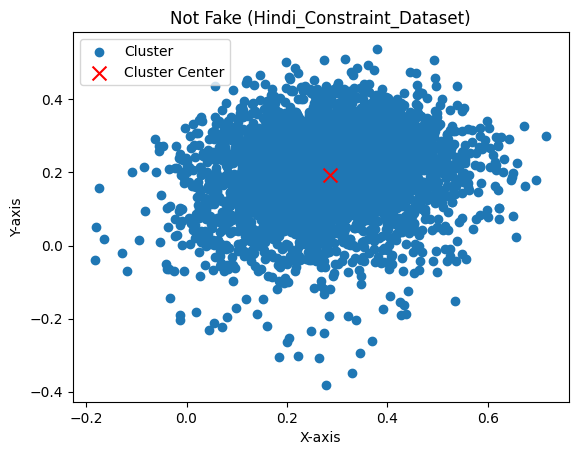

In [ ]:
import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load your embeddings from the file
embeddings = torch.load('Not_Hate_Hin_embeddings.pt')

# Convert the embeddings to a NumPy array and flatten it
embeddings = embeddings.numpy().reshape(embeddings.shape[0], -1)

# Create a KMeans instance with k=1
kmeans = KMeans(n_clusters=1)

# Fit the KMeans model to your data
kmeans.fit(embeddings)

# Get the cluster assignments for each data point
labels = kmeans.labels_

# Get the cluster center
cluster_center = kmeans.cluster_centers_[0]

# Calculate distances of each point to the cluster center
distances = np.linalg.norm(embeddings - cluster_center, axis=1)

# Fit a normal distribution to the distances
mu, sigma = norm.fit(distances)

# Define a threshold based on the normal distribution (e.g., mu ± 3 * sigma)
distance_threshold = 3 * sigma

# Remove outliers
filtered_embeddings = embeddings[distances <= mu + distance_threshold]

# Visualize the filtered cluster
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], label='Cluster')

# Mark the cluster center with a different representation
plt.scatter(cluster_center[0], cluster_center[1], c='red', marker='x', s=100, label='Cluster Center')

# Set labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Not Hate (Hindi_Constraint_Dataset)')
plt.legend(loc='best')

# Show the plot
plt.show()

In [ ]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

# Utilize GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the new dataset
import pandas as pd

# Assuming you have a CSV file with the dataset
df = pd.read_excel('ML_Project_Run.xlsx')

# Check for records where Hate is 1
hate_records = df

# Load BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased").to(device)

# Create a new column for Hindi embeddings
df['Not_Hate_Hin_Cluster_Euclidean'] = 0.0

# Calculate embeddings for Hindi text and measure distance
for index, row in tqdm(hate_records.iterrows(), total=len(hate_records), desc="Calculating Embeddings"):
    hindi_text = row['Cleaned_Column']

    # Tokenize and get embeddings
    inputs = tokenizer(hindi_text, return_tensors="pt", truncation=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().cpu().numpy()

    distance = np.linalg.norm(embeddings - cluster_center)

    # Update the 'hin_dis' column
    df.at[index, 'Not_Hate_Hin_Cluster_Euclidean'] = distance

df.to_excel('ML_Project_Run.xlsx', index=False)

df.head(5)

Calculating Embeddings: 100%|██████████| 8014/8014 [01:49<00:00, 73.02it/s]


,Tweet,Fake,Hate,Cleaned_Column,final_english_text,Fake_Hin_Cluster_Euclidean,Not_Fake_Hin_Cluster_Euclidean
0,@SPDhoke3 @RahulGandhi Lana shuru kar diya gay...,0,0,स्पधोके३ राहुलगांधी लाना शुरू कर दिया गया थ...,"Just like coronavirus spread in China, student...",12.928349,12.902511
1,"@ndtv Corona virus ka warriss lagta zinda hai,...",0,0,एनडीटीवी कोरोना वायरस का वारिस लगता जिंदा है...,NDTV seems to be the heir of the corona virus ...,12.914305,12.886197
2,Iski baaton se lag raha hai ki corona virus na...,1,1,इसकी बातों से लग रहा है की कोरोना वायरस नही ...,From its talk it appears that it is not the co...,12.978409,12.970811
3,Customer : Ek accha sa Corona Virus Dikhao na ...,1,0,कस्टमर एक अच्छा सा कोरोना वायरस दिखाओ ना भ...,There is no other variant of CoronaMade in Chi...,12.686148,12.669266
4,"Bohat Bolty Thy:\n\n""Made In China, Ziyada Nah...",1,0,बोहत बोल्टी थी मेड इन चीना ज़ियादा नही चलेग...,There was a lot of Bolty Made in China Ziyada ...,13.065220,13.077336


In [ ]:
import pandas as pd

# Assuming your dataset is loaded into a DataFrame called 'df'
# Replace 'your_dataset.csv' with the actual file name or path if needed
df = pd.read_excel('Hate_output_file.xlsx')

# Adding the two columns and creating a new column 'Fake_Hin_Cos_Sim'
df['Final_Hate_Hin_Dot'] = df['Hate_Hin_Dot'] + df['NotHate_Hin_Dot']

# Save the modified DataFrame to a new CSV file
df.to_excel('Hate_output_file.xlsx', index=False)


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MBERT model and tokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# Load your dataset
data = pd.read_excel("Hate_output_file.xlsx")
texts = data["Cleaned_Column"].tolist()
distances_fake = data["Hate_Hin_Dot"].tolist()

# Generate combined embeddings
embeddings = []
# Initialize tqdm to display progress
with tqdm(total=len(texts), desc="Generating Embeddings") as pbar:
    for text, distance_fake in zip(texts, distances_fake):
        # Tokenize the text
        input_ids = tokenizer.encode(text, return_tensors="pt").to(device)

        # Get the initial text embedding
        with torch.no_grad():
            output = model(input_ids)
        embedding = output.last_hidden_state[0][0]

        # Normalize the distances
        normalized_distance_fake = distance_fake  # Use only "Distance_Hin_Fake"

        # Combine text embedding and distances using scaling factors
        combined_embedding = embedding * 0.5 + torch.tensor([normalized_distance_fake]).to(device) * 0.5

        # Append the combined embedding to the list
        embeddings.append(combined_embedding.cpu().tolist())

        # Update tqdm progress bar
        pbar.update(1)

embeddings = [torch.tensor(embedding) for embedding in embeddings]
torch.save(torch.stack(embeddings), "Embeddings_With_Dot_Pro_768_equal_scaling_Fake.pt")
embedd = torch.load("Embeddings_With_Dot_Pro_768_equal_scaling_Fake.pt")
print("Shape of the Embeddings: ", embedd.shape)

Generating Embeddings: 100%|██████████| 8014/8014 [01:53<00:00, 70.81it/s]


Shape of the Embeddings:  torch.Size([8014, 768])


In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Load the dataset from your .xlsx file
input_file = "hate_output_file.xlsx"
df = pd.read_excel(input_file)

# Load embeddings from "embeddings.pt"
all_embeddings = torch.load("Embeddings_With_Dot_Pro_768_equal_scaling_Fake.pt").numpy()  # Load with PyTorch and convert to NumPy array

# Prepare the labels
labels_hate = tf.convert_to_tensor(df['Fake'].values)

# Convert TensorFlow tensors to NumPy arrays
labels_hate = labels_hate.numpy()

# Split the data into train and test sets
train_embeddings, test_embeddings, train_labels_hate, test_labels_hate = train_test_split(all_embeddings, labels_hate, test_size=0.2, random_state=42)

# Define a custom dataset
class HateDataset(tf.keras.utils.Sequence):
    def _init_(self, embeddings, labels_hate, batch_size):
        self.embeddings = embeddings
        self.labels_hate = labels_hate
        self.batch_size = batch_size

    def _len_(self):
        return len(self.embeddings) // self.batch_size

    def _getitem_(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        return self.embeddings[start:end], self.labels_hate[start:end]

# Create data loaders for training and testing
batch_size = 32
train_dataset = HateDataset(train_embeddings, train_labels_hate, batch_size)
test_dataset = HateDataset(test_embeddings, test_labels_hate, batch_size)

# Define the hate detection model in TensorFlow
def create_hate_model(input_dim):
    input_layer = tf.keras.layers.Input(shape=(input_dim,))
    hidden_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

hate_model = create_hate_model(all_embeddings.shape[1])
hate_model.compile(loss='huber_loss', optimizer='adam', metrics=['accuracy'])

# Initialize and train the hate detection model
num_epochs = 7

# Lists to store metrics for each epoch
accuracy_list = []
f1_list = []
epoch_list = []
training_loss_list = []
validation_loss_list = []

max_f1 = 0  # Variable to store the highest F1-score

best_epoch = 0  # Variable to store the epoch with the highest F1-score

for epoch in range(num_epochs):
    epoch_list.append(epoch + 1)
    epoch_training_loss = []  # List to store training loss for this epoch
    for batch in train_dataset:
        embeddings, labels_hate = batch
        loss = hate_model.train_on_batch(embeddings, labels_hate)
        epoch_training_loss.append(loss)  # Append training loss for this batch

    # Store average training loss for this epoch
    training_loss_list.append(np.mean(epoch_training_loss))

    # Evaluation on the test set
    hate_preds = []
    for batch in test_dataset:
        embeddings, labels_hate = batch
        hate_pred = hate_model.predict(embeddings)
        hate_preds.extend(hate_pred)

    # Ensure consistent lengths of test labels and predictions
    min_length = min(len(test_labels_hate), len(hate_preds))
    test_labels_hate = test_labels_hate[:min_length]
    hate_preds_binary = (np.array(hate_preds)[:min_length] >= 0.5).astype(int)

    # Calculate metrics for hate detection
    accuracy = accuracy_score(test_labels_hate, hate_preds_binary)
    precision = precision_score(test_labels_hate, hate_preds_binary)
    recall = recall_score(test_labels_hate, hate_preds_binary)
    f1 = f1_score(test_labels_hate, hate_preds_binary)

    print(f"Hate Metrics - Epoch {epoch + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    accuracy_list.append(accuracy)
    f1_list.append(f1)

    # Update max_f1 and best_epoch if a new high F1-score is achieved
    if f1 > max_f1:
        max_f1 = f1
        best_epoch = epoch + 1

    # Evaluate the model on the validation set
    val_loss = hate_model.evaluate(test_dataset)
    validation_loss_list.append(val_loss[0])

# Print the highest F1-score and best epoch
print(f"Highest F1-Score for Hate: {max_f1:.4f} at Epoch {best_epoch}")

# Display the classification report at the end
print("Classification Report - Hate Detection:")
print(classification_report(test_labels_hate, hate_preds_binary))


# Calculate overall F1-Score for test data
overall_f1 = f1_score(test_labels_hate, hate_preds_binary)

print("======================================================")
print("Test Data Classification Report")
print("------------------------------------------------------")
print("Hate F1-Score : ", overall_f1)
print("------------------------------------------------------")


# Plotting the metrics
plt.figure(figsize=(12, 8))

# Plotting Accuracy
plt.plot(epoch_list, accuracy_list, label='Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting F1-score
plt.figure(figsize=(12, 8))
plt.plot(epoch_list, f1_list, label='F1 Score', marker='o')
plt.title('F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_list,training_loss_list , label='Training Loss', marker='o')
plt.plot(epoch_list, validation_loss_list , label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: HateDataset() takes no arguments

In [ ]:
# TSNE


import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the embeddings from the .pt file
embeddings = torch.load("modified_Mbert_embeddings_with_Hate_Dot_Pro_769.pt")

# Assuming embeddings is a tensor of shape (num_embeddings, embedding_dim)
# Move the embeddings to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embeddings = embeddings.to(device)

# Convert embeddings to numpy array
embeddings_np = embeddings.cpu().numpy()

# Reduce the dimensionality using TSNE on GPU
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_np)

# Plot the embeddings in 2D space
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s=10)  # Adjust the size 's' if needed
plt.title('TSNE Visualization of Embeddings for MBERT with Dot-Product Values as additional Features 769 Dim')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.show()